In [ ]:
# ===============================
# 1. IMPORTS & SETUP
# ===============================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 128
BATCH_SIZE = 16

In [ ]:
# ===============================
# 2. LOAD & PREPROCESS DATA
# ===============================
# Set random seed for reproducibility
SEED = 42  # You can choose any integer value

# Load the dataset from Excel file
df = pd.read_excel('dataset/Konkani_Dataset.xlsx')

# Display basic information about the dataset
print(f"Total samples in dataset: {len(df)}")
print(f"Column names: {df.columns.tolist()}")
print(f"Idiom distribution: {df['Idiom'].value_counts().to_dict()}")
print(f"Metaphor distribution: {df['Metaphor'].value_counts().to_dict()}")

# Prepare datasets based on the existing Split column for Idiom detection
idiom_train_df = df[df['Split'] == 'Train']
idiom_val_df = df[df['Split'] == 'Val']
idiom_test_df = df[df['Split'] == 'Test']

print("\n=== IDIOM DETECTION TASK (Using original split) ===")
print(f"Idiom training set size: {len(idiom_train_df)}")
print(f"Idiom validation set size: {len(idiom_val_df)}")
print(f"Idiom test set size: {len(idiom_test_df)}")
print(f"Idiom train/test ratio: {len(idiom_train_df)/(len(idiom_train_df)+len(idiom_test_df)):.2f}/{len(idiom_test_df)/(len(idiom_train_df)+len(idiom_test_df)):.2f}")

# Create a balanced dataset for metaphor detection (100 Yes, 100 No)
print("\n=== METAPHOR DETECTION TASK (Balanced subset) ===")
metaphor_yes = df[df['Metaphor'] == 'Yes'].head(100)
metaphor_no = df[df['Metaphor'] == 'No'].head(100)
metaphor_df = pd.concat([metaphor_yes, metaphor_no]).reset_index(drop=True)

# Create train-test split for metaphor detection (80% train, 20% test)
metaphor_train_df, metaphor_test_df = train_test_split(
    metaphor_df,
    test_size=0.2,
    random_state=SEED,
    stratify=metaphor_df['Metaphor']  # Ensure balanced split
)

print(f"Balanced metaphor dataset size: {len(metaphor_df)}")
print(f"Metaphor distribution: {metaphor_df['Metaphor'].value_counts().to_dict()}")
print(f"Metaphor training set size: {len(metaphor_train_df)}")
print(f"Metaphor test set size: {len(metaphor_test_df)}")


Total samples in dataset: 6520
Column names: ['Id', 'Expression', 'Sentence', 'Idiom', 'Metaphor', 'Split', 'Unnamed: 6', 'Unnamed: 7']
Idiom distribution: {'Yes': 4399, 'No': 2121}
Metaphor distribution: {'No': 383, 'Yes': 117}

=== IDIOM DETECTION TASK (Using original split) ===
Idiom training set size: 4990
Idiom validation set size: 0
Idiom test set size: 1530
Idiom train/test ratio: 0.77/0.23

=== METAPHOR DETECTION TASK (Balanced subset) ===
Balanced metaphor dataset size: 200
Metaphor distribution: {'Yes': 100, 'No': 100}
Metaphor training set size: 160
Metaphor test set size: 40


In [ ]:
# ===============================
# 3. TOKENIZER + DATASET
# ===============================
# Initialize the multilingual BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

# Define a dataset class that works for both idiom and metaphor classification
class TextClassificationDataset(Dataset):
    def __init__(self, dataframe, tokenizer, task_type="idiom", max_len=MAX_LEN):
        """
        Dataset class for text classification tasks

        Args:
            dataframe: Pandas DataFrame containing the data
            tokenizer: Tokenizer to use for encoding text
            task_type: Type of classification task ("idiom" or "metaphor")
            max_len: Maximum sequence length for tokenization
        """
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.task_type = task_type
        self.max_len = max_len

        # Set the label column based on task type
        self.label_col = "Idiom" if task_type == "idiom" else "Metaphor"

        # Convert Yes/No labels to numeric values
        self.dataframe["label"] = self.dataframe[self.label_col].map({"Yes": 1, "No": 0})

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Format text based on task type
        prefix = "[IDIOM]" if self.task_type == "idiom" else "[METAPHOR]"
        text_to_encode = f"{prefix} {row['Expression']} [SEP] {row['Sentence']}"

        # Tokenize the text
        encoding = self.tokenizer(
            text_to_encode,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "label": torch.tensor(row["label"], dtype=torch.long)
        }

# ===============================
# IDIOM CLASSIFICATION SETUP
# ===============================
# Create validation set from training data if needed
if len(idiom_val_df) == 0:
    print("Creating validation set from training data...")
    # Get unique expressions to avoid data leakage
    unique_expressions = idiom_train_df["Expression"].unique()

    # Split expressions into train and val (no expression overlap)
    expr_train, expr_val = train_test_split(
        unique_expressions, test_size=0.2, random_state=42
    )

    # Assign expression-based split
    idiom_val_df = idiom_train_df[idiom_train_df["Expression"].isin(expr_val)].copy()
    idiom_train_df = idiom_train_df[idiom_train_df["Expression"].isin(expr_train)].copy()

print(f"Idiom - Train rows: {len(idiom_train_df)}, Val rows: {len(idiom_val_df)}, Test rows: {len(idiom_test_df)}")

# Create idiom datasets
idiom_train_ds = TextClassificationDataset(idiom_train_df, tokenizer, task_type="idiom")
idiom_val_ds = TextClassificationDataset(idiom_val_df, tokenizer, task_type="idiom")
idiom_test_ds = TextClassificationDataset(idiom_test_df, tokenizer, task_type="idiom")

# Create idiom dataloaders
idiom_train_loader = DataLoader(idiom_train_ds, batch_size=BATCH_SIZE, shuffle=True)
idiom_val_loader = DataLoader(idiom_val_ds, batch_size=BATCH_SIZE)
idiom_test_loader = DataLoader(idiom_test_ds, batch_size=BATCH_SIZE)

# ===============================
# METAPHOR CLASSIFICATION SETUP
# ===============================
print(f"Metaphor - Train rows: {len(metaphor_train_df)}, Test rows: {len(metaphor_test_df)}")

# Create metaphor datasets
metaphor_train_ds = TextClassificationDataset(metaphor_train_df, tokenizer, task_type="metaphor")
metaphor_test_ds = TextClassificationDataset(metaphor_test_df, tokenizer, task_type="metaphor")

# Create metaphor dataloaders
metaphor_train_loader = DataLoader(metaphor_train_ds, batch_size=BATCH_SIZE, shuffle=True)
metaphor_test_loader = DataLoader(metaphor_test_ds, batch_size=BATCH_SIZE)

print("Dataset and DataLoader setup complete!")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Creating validation set from training data...
Idiom - Train rows: 4029, Val rows: 961, Test rows: 1530
Metaphor - Train rows: 160, Test rows: 40
Dataset and DataLoader setup complete!


<ipython-input-4-c9989d0439c3>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["label"] = self.dataframe[self.label_col].map({"Yes": 1, "No": 0})


In [ ]:
# ===============================
# 4. MODEL: mBERT + BiLSTM
# ===============================
class BERT_LSTM(nn.Module):
    def __init__(self, hidden_dim=128, num_classes=2):
        """
        BERT + BiLSTM model for text classification

        Args:
            hidden_dim: Hidden dimension of the LSTM
            num_classes: Number of output classes
        """
        super(BERT_LSTM, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        lstm_out, _ = self.lstm(outputs.last_hidden_state)
        pooled = torch.mean(lstm_out, dim=1)
        return self.fc(self.dropout(pooled))

# Create separate models for idiom and metaphor classification
print("Initializing models...")
idiom_model = BERT_LSTM(hidden_dim=128, num_classes=2).to(device)
metaphor_model = BERT_LSTM(hidden_dim=128, num_classes=2).to(device)

# Initialize optimizers and loss function
idiom_optimizer = torch.optim.AdamW(idiom_model.parameters(), lr=2e-5)
metaphor_optimizer = torch.optim.AdamW(metaphor_model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

print(f"Models initialized on device: {device}")
print("Idiom model and Metaphor model share the same architecture but will be trained separately")


Initializing models...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Models initialized on device: cuda
Idiom model and Metaphor model share the same architecture but will be trained separately


In [ ]:
# ===============================
# 5. TRAINING & VALIDATION
# ===============================
def train(model, loader, optimizer):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Training"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader):
    """Validate the model on validation set"""
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, task_type="idiom"):
    """Evaluate the model and print classification report"""
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # Set appropriate target names based on task type
    if task_type == "idiom":
        target_names = ["Non-Idiom", "Idiom"]
    else:  # metaphor
        target_names = ["Non-Metaphor", "Metaphor"]

    print(classification_report(
        targets, predictions,
        labels=[0, 1],
        target_names=target_names,
        zero_division=0
    ))

    return predictions, targets


In [ ]:
# ===============================
# 6. EARLY STOPPING TRAINING
# ===============================
def train_with_early_stopping(model, train_loader, val_loader, optimizer, task_name, epochs=20, patience=10):
    """Train model with early stopping"""
    print(f"\n=== Training {task_name} Model ===")
    best_val_loss = float('inf')
    patience_counter = 0
    best_model = None

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}")
        train_loss = train(model, train_loader, optimizer)
        val_loss = validate(model, val_loader)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            patience_counter = 0
            print("✅ Validation loss improved, saving model.")
        else:
            patience_counter += 1
            print("⚠️ No improvement.")

        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

    # Load best model
    model.load_state_dict(best_model)
    print(f"\n=== {task_name} Model Training Complete ===")
    return model

# Train idiom model
EPOCHS = 20
PATIENCE = 10

# Check if validation set exists for idiom task
if len(idiom_val_df) > 0:
    idiom_model = train_with_early_stopping(
        idiom_model, idiom_train_loader, idiom_val_loader,
        idiom_optimizer, "Idiom", EPOCHS, PATIENCE
    )
    print("\n=== Idiom Model Validation Results ===")
    evaluate(idiom_model, idiom_val_loader, task_type="idiom")
else:
    print("No validation set available for idiom task. Skipping training.")

# Train metaphor model
# Create validation set for metaphor if needed
metaphor_val_df = metaphor_test_df  # Using test set as validation for simplicity
metaphor_val_ds = TextClassificationDataset(metaphor_val_df, tokenizer, task_type="metaphor")
metaphor_val_loader = DataLoader(metaphor_val_ds, batch_size=BATCH_SIZE)

metaphor_model = train_with_early_stopping(
    metaphor_model, metaphor_train_loader, metaphor_val_loader,
    metaphor_optimizer, "Metaphor", EPOCHS, PATIENCE
)
print("\n=== Metaphor Model Validation Results ===")
evaluate(metaphor_model, metaphor_val_loader, task_type="metaphor")



=== Training Idiom Model ===

Epoch 1


Training: 100%|██████████| 252/252 [01:34<00:00,  2.68it/s]


Train Loss: 0.5908 | Val Loss: 0.4923
✅ Validation loss improved, saving model.

Epoch 2


Training: 100%|██████████| 252/252 [01:36<00:00,  2.60it/s]


Train Loss: 0.4529 | Val Loss: 0.4495
✅ Validation loss improved, saving model.

Epoch 3


Training: 100%|██████████| 252/252 [01:36<00:00,  2.60it/s]


Train Loss: 0.3422 | Val Loss: 0.4631
⚠️ No improvement.

Epoch 4


Training: 100%|██████████| 252/252 [01:36<00:00,  2.60it/s]


Train Loss: 0.2431 | Val Loss: 0.4796
⚠️ No improvement.

Epoch 5


Training: 100%|██████████| 252/252 [01:36<00:00,  2.60it/s]


Train Loss: 0.1700 | Val Loss: 0.6011
⚠️ No improvement.

Epoch 6


Training: 100%|██████████| 252/252 [01:36<00:00,  2.61it/s]


Train Loss: 0.1572 | Val Loss: 0.5771
⚠️ No improvement.

Epoch 7


Training: 100%|██████████| 252/252 [01:36<00:00,  2.61it/s]


Train Loss: 0.1073 | Val Loss: 0.6529
⚠️ No improvement.

Epoch 8


Training: 100%|██████████| 252/252 [01:36<00:00,  2.61it/s]


Train Loss: 0.0693 | Val Loss: 0.7647
⚠️ No improvement.

Epoch 9


Training: 100%|██████████| 252/252 [01:36<00:00,  2.61it/s]


Train Loss: 0.0603 | Val Loss: 0.7662
⚠️ No improvement.

Epoch 10


Training: 100%|██████████| 252/252 [01:36<00:00,  2.61it/s]


Train Loss: 0.0457 | Val Loss: 0.8565
⚠️ No improvement.

Epoch 11


Training: 100%|██████████| 252/252 [01:36<00:00,  2.61it/s]


Train Loss: 0.0435 | Val Loss: 0.8839
⚠️ No improvement.

Epoch 12


Training: 100%|██████████| 252/252 [01:36<00:00,  2.60it/s]


Train Loss: 0.0474 | Val Loss: 0.9024
⚠️ No improvement.
⏹️ Early stopping triggered.

=== Idiom Model Training Complete ===

=== Idiom Model Validation Results ===
              precision    recall  f1-score   support

   Non-Idiom       0.73      0.52      0.61       295
       Idiom       0.81      0.92      0.86       666

    accuracy                           0.80       961
   macro avg       0.77      0.72      0.74       961
weighted avg       0.79      0.80      0.78       961


=== Training Metaphor Model ===

Epoch 1


Training: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Train Loss: 0.6954 | Val Loss: 0.6693
✅ Validation loss improved, saving model.

Epoch 2


Training: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Train Loss: 0.6305 | Val Loss: 0.5762
✅ Validation loss improved, saving model.

Epoch 3


Training: 100%|██████████| 10/10 [00:03<00:00,  2.63it/s]


Train Loss: 0.4559 | Val Loss: 0.6688
⚠️ No improvement.

Epoch 4


Training: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Train Loss: 0.4296 | Val Loss: 0.4281
✅ Validation loss improved, saving model.

Epoch 5


Training: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Train Loss: 0.3129 | Val Loss: 0.3397
✅ Validation loss improved, saving model.

Epoch 6


Training: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Train Loss: 0.1782 | Val Loss: 0.3912
⚠️ No improvement.

Epoch 7


Training: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Train Loss: 0.2120 | Val Loss: 0.5613
⚠️ No improvement.

Epoch 8


Training: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Train Loss: 0.1293 | Val Loss: 0.3767
⚠️ No improvement.

Epoch 9


Training: 100%|██████████| 10/10 [00:03<00:00,  2.62it/s]


Train Loss: 0.0697 | Val Loss: 0.5031
⚠️ No improvement.

Epoch 10


Training: 100%|██████████| 10/10 [00:03<00:00,  2.59it/s]


Train Loss: 0.0545 | Val Loss: 0.3793
⚠️ No improvement.

Epoch 11


Training: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Train Loss: 0.0192 | Val Loss: 0.5173
⚠️ No improvement.

Epoch 12


Training: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Train Loss: 0.0280 | Val Loss: 0.3643
⚠️ No improvement.

Epoch 13


Training: 100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


Train Loss: 0.0294 | Val Loss: 0.5934
⚠️ No improvement.

Epoch 14


Training: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Train Loss: 0.0185 | Val Loss: 0.7709
⚠️ No improvement.

Epoch 15


Training: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


Train Loss: 0.0969 | Val Loss: 0.4935
⚠️ No improvement.
⏹️ Early stopping triggered.

=== Metaphor Model Training Complete ===

=== Metaphor Model Validation Results ===
              precision    recall  f1-score   support

Non-Metaphor       0.80      1.00      0.89        20
    Metaphor       1.00      0.75      0.86        20

    accuracy                           0.88        40
   macro avg       0.90      0.88      0.87        40
weighted avg       0.90      0.88      0.87        40



([np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0)],
 [np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(0),
  np.int64(1),
  np.int64(0),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int64(1),
  np.int6

In [ ]:
# ===============================
# 7. ATTENTION HEAD IMPORTANCE ANALYSIS
# ===============================
def analyze_attention_importance(model, val_loader, model_name="Model"):
    """
    Analyze and visualize attention head importance for a given model

    Args:
        model: The model to analyze
        val_loader: Validation data loader
        model_name: Name of the model for display purposes
    """
    head_grads = {}

    def save_attention_hook(layer_id, head_id):
        def hook_fn(grad):
            key = (layer_id, head_id)
            grad_norm = grad.detach().pow(2).sum().item()
            head_grads[key] = head_grads.get(key, 0) + grad_norm
        return hook_fn

    def register_attention_hooks(model):
        hooks = []
        for layer_id, layer in enumerate(model.bert.encoder.layer):
            def backward_hook_fn(module, grad_input, grad_output, lid=layer_id):
                batch_size, seq_len, hidden = grad_output[0].shape
                head_dim = hidden // layer.attention.self.num_attention_heads
                reshaped = grad_output[0].view(batch_size, seq_len, -1, head_dim).mean(1)
                for head_id in range(reshaped.shape[1]):
                    g = reshaped[:, head_id, :].reshape(-1)
                    save_attention_hook(lid, head_id)(g)
            hooks.append(layer.output.register_full_backward_hook(backward_hook_fn))
        return hooks

    print(f"\n=== Analyzing Attention Head Importance for {model_name} ===")

    # Register hooks and compute gradients
    model.train()  # required for cuDNN + LSTM backprop
    hooks = register_attention_hooks(model)

    with torch.set_grad_enabled(True):  # Ensures autograd is fully on
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)

            model.zero_grad()
            loss.backward()
            break  # only one batch needed

    # Remove hooks
    for h in hooks:
        h.remove()

    model.eval()

    # Normalize gradients and organize by layer
    layer_head_importance = {}
    for (layer, head), grad_val in head_grads.items():
        layer_head_importance.setdefault(layer, []).append(grad_val)

    # Print normalized importance scores
    print(f"\n{model_name} Attention Head Importance (normalized):")
    for layer in sorted(layer_head_importance):
        scores = np.array(layer_head_importance[layer])
        norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
        print(f"Layer {layer}: {np.round(norm_scores, 3).tolist()}")

    # Visualize as heatmap
    num_layers = max(layer_head_importance.keys()) + 1
    num_heads = max(len(v) for v in layer_head_importance.values())
    importance_matrix = np.zeros((num_layers, num_heads))

    for layer, scores in layer_head_importance.items():
        scores = np.array(scores)
        scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)  # normalize again
        importance_matrix[layer, :len(scores)] = scores

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        importance_matrix,
        annot=True,
        cmap="YlGnBu",
        xticklabels=[f"H{i}" for i in range(num_heads)],
        yticklabels=[f"L{i}" for i in range(num_layers)],
        cbar_kws={'label': 'Normalized Importance'}
    )
    plt.title(f"Attention Head Importance Heatmap (Layer vs. Head)")
    plt.xlabel("Head")
    plt.ylabel("Layer")
    plt.tight_layout()
    plt.savefig(f"{model_name.lower().replace(' ', '_')}_attention_importance.png")
    plt.show()

    return layer_head_importance



=== IDIOM MODEL ANALYSIS ===

=== Analyzing Attention Head Importance for Idiom ===

Idiom Attention Head Importance (normalized):
Layer 0: [0.41, 0.024, 0.131, 0.199, 0.432, 0.392, 0.934, 0.506, 0.477, 0.887, 0.423, 0.0]
Layer 1: [0.468, 0.408, 0.341, 0.182, 0.648, 0.736, 0.657, 0.089, 0.067, 0.954, 0.645, 0.0]
Layer 2: [0.369, 0.85, 0.392, 0.777, 0.967, 0.641, 0.681, 0.342, 0.217, 0.567, 0.652, 0.0]
Layer 3: [0.51, 0.629, 0.222, 0.726, 0.947, 0.611, 0.925, 0.042, 0.207, 0.73, 0.387, 0.0]
Layer 4: [0.34, 0.0, 0.189, 0.406, 0.706, 0.935, 0.241, 0.263, 0.499, 0.094, 0.126, 0.409]
Layer 5: [0.373, 0.0, 0.123, 0.12, 0.407, 0.363, 0.175, 0.231, 0.533, 0.071, 0.126, 0.863]
Layer 6: [0.214, 0.025, 0.521, 0.296, 0.145, 0.369, 0.318, 0.0, 0.204, 0.381, 0.316, 0.823]
Layer 7: [0.384, 0.165, 0.196, 0.132, 0.456, 0.351, 0.677, 0.596, 0.26, 0.0, 0.543, 0.307]
Layer 8: [0.416, 0.222, 0.0, 0.33, 0.242, 0.045, 0.122, 0.594, 0.233, 0.048, 0.196, 0.147]
Layer 9: [0.317, 0.173, 0.256, 0.396, 0.393, 0.0

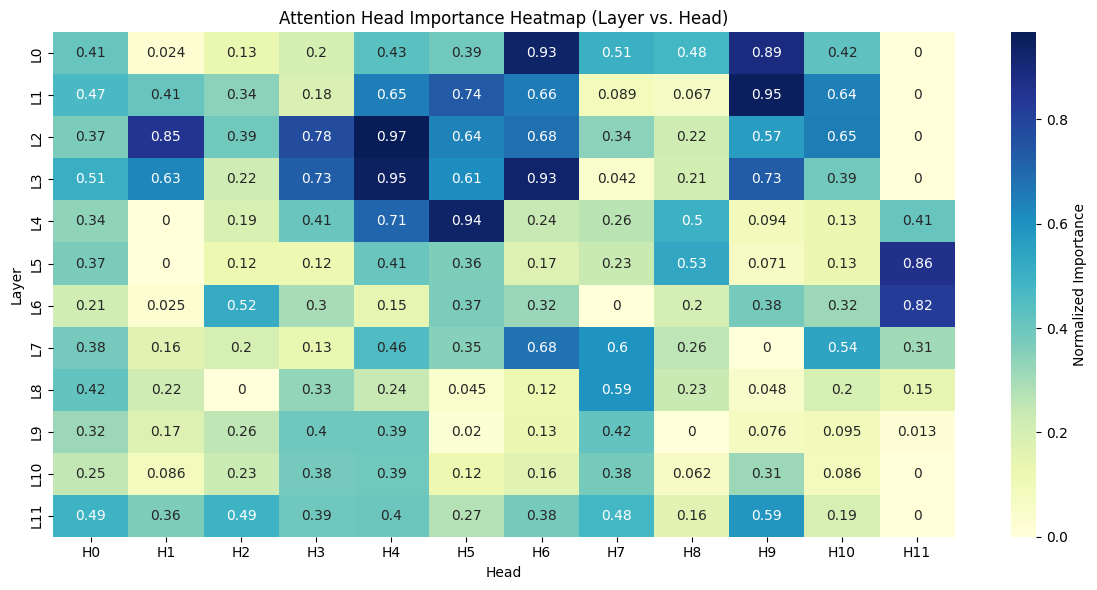


=== METAPHOR MODEL ANALYSIS ===

=== Analyzing Attention Head Importance for Metaphor ===

Metaphor Attention Head Importance (normalized):
Layer 0: [0.996, 0.18, 0.0, 0.176, 0.197, 0.286, 0.433, 0.129, 0.336, 0.678, 0.077, 0.349]
Layer 1: [0.996, 0.253, 0.0, 0.005, 0.619, 0.625, 0.587, 0.097, 0.519, 0.806, 0.077, 0.257]
Layer 2: [0.995, 0.453, 0.215, 0.558, 0.637, 0.733, 0.593, 0.138, 0.114, 0.225, 0.0, 0.318]
Layer 3: [0.788, 0.415, 0.107, 0.321, 0.997, 0.163, 0.367, 0.0, 0.147, 0.186, 0.252, 0.25]
Layer 4: [0.991, 0.504, 0.615, 0.537, 0.904, 0.345, 0.712, 0.0, 0.472, 0.182, 0.672, 0.047]
Layer 5: [0.57, 0.919, 0.728, 0.98, 0.571, 0.91, 0.346, 0.184, 0.806, 0.0, 0.602, 0.452]
Layer 6: [0.401, 0.285, 0.512, 0.683, 0.548, 0.976, 0.16, 0.529, 0.906, 0.0, 0.422, 0.497]
Layer 7: [0.457, 0.69, 0.744, 0.796, 0.616, 0.749, 0.0, 0.294, 0.698, 0.658, 0.947, 0.437]
Layer 8: [0.552, 0.358, 0.623, 0.854, 0.539, 0.53, 0.139, 0.176, 0.599, 0.828, 0.572, 0.0]
Layer 9: [0.412, 0.313, 0.195, 0.861, 0

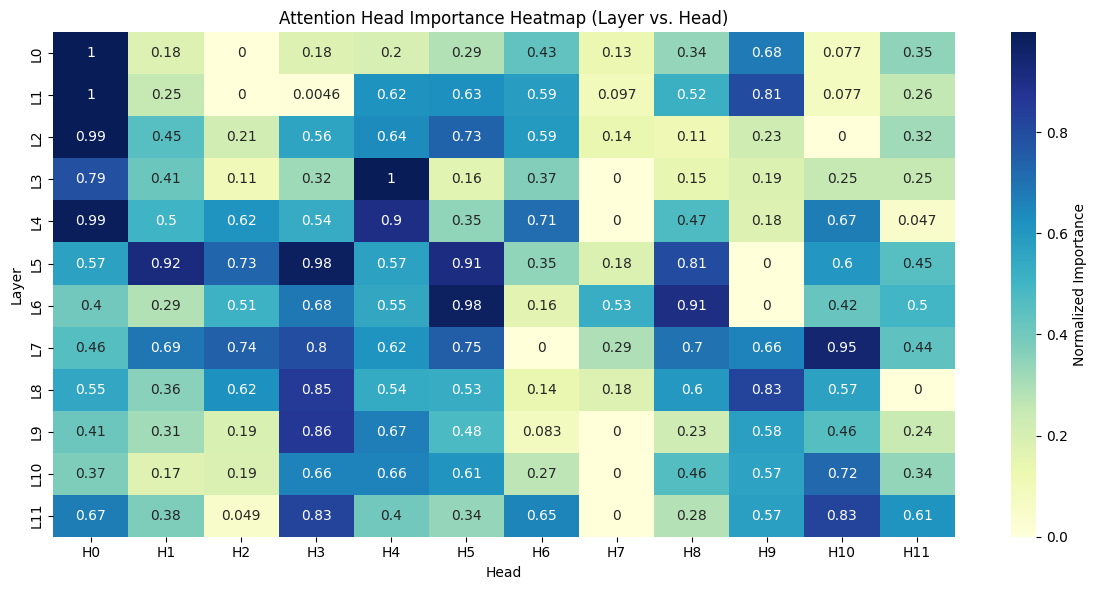

In [ ]:
# ===============================
# 8. ANALYZE MODELS SEPARATELY
# ===============================
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Analyze attention head importance for idiom model
print("\n=== IDIOM MODEL ANALYSIS ===")
idiom_importance = analyze_attention_importance(idiom_model, idiom_val_loader, "Idiom")

# Analyze attention head importance for metaphor model
print("\n=== METAPHOR MODEL ANALYSIS ===")
metaphor_importance = analyze_attention_importance(metaphor_model, metaphor_val_loader, "Metaphor")


In [ ]:
# ===============================
# 9. ATTENTION HEAD PRUNING & EVALUATION
# ===============================
# Create a function to convert layer_head_importance to importance_matrix
def create_importance_matrix(layer_head_importance):
    num_layers = max(layer_head_importance.keys()) + 1
    num_heads = max(len(v) for v in layer_head_importance.values())
    importance_matrix = np.zeros((num_layers, num_heads))

    for layer, scores in layer_head_importance.items():
        scores = np.array(scores)
        scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)  # normalize
        importance_matrix[layer, :len(scores)] = scores

    return importance_matrix

# Create a function to prune and evaluate models
def prune_and_evaluate_model(model, layer_head_importance, test_loader, model_name="Model"):
    # Convert layer_head_importance to importance_matrix
    importance_matrix = create_importance_matrix(layer_head_importance)

    # Create head mask (0 = disable, 1 = keep)
    head_mask = torch.ones_like(torch.tensor(importance_matrix), dtype=torch.float32)
    head_mask[importance_matrix == 0.0] = 0.0  # Turn off heads with 0 importance
    head_mask = head_mask.to(device)

    # Count pruned heads
    pruned_heads_count = torch.sum(head_mask == 0.0).item()
    total_heads = head_mask.numel()
    pruning_percentage = (pruned_heads_count / total_heads) * 100

    print(f"{model_name} Pruning: {pruned_heads_count} out of {total_heads} heads pruned ({pruning_percentage:.2f}%)")

    # Create pruned model wrapper
    pruned_model = PrunedBERT_LSTM(model, head_mask).to(device)

    # Evaluate original and pruned models
    print(f"\n{model_name} Original Model (No Pruning)")
    evaluate(model, test_loader, task_type=model_name.lower())

    print(f"\n{model_name} Pruned Model (Heads with Importance = 0 Disabled)")
    evaluate(pruned_model, test_loader, task_type=model_name.lower())

    return pruned_model, pruning_percentage

# Define the pruned model wrapper class
class PrunedBERT_LSTM(nn.Module):
    def __init__(self, base_model, head_mask):
        super().__init__()
        self.base_model = base_model
        self.head_mask = head_mask

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=self.head_mask
        )
        lstm_out, _ = self.base_model.lstm(outputs.last_hidden_state)
        pooled = torch.mean(lstm_out, dim=1)
        return self.base_model.fc(self.base_model.dropout(pooled))

# Prune and evaluate idiom model
print("\n=== IDIOM MODEL PRUNING ===")
idiom_pruned_model, idiom_pruning_percentage = prune_and_evaluate_model(
    idiom_model,
    idiom_importance,  # Using idiom_importance directly
    idiom_test_loader,
    "Idiom"
)

# Prune and evaluate metaphor model
print("\n=== METAPHOR MODEL PRUNING ===")
metaphor_pruned_model, metaphor_pruning_percentage = prune_and_evaluate_model(
    metaphor_model,
    metaphor_importance,  # Using metaphor_importance directly
    metaphor_test_loader,
    "Metaphor"
)

# Print summary of pruning results
print("\n=== PRUNING SUMMARY ===")
print(f"Idiom model: {idiom_pruning_percentage:.2f}% of attention heads pruned")
print(f"Metaphor model: {metaphor_pruning_percentage:.2f}% of attention heads pruned")



=== IDIOM MODEL PRUNING ===
Idiom Pruning: 12 out of 144 heads pruned (8.33%)

Idiom Original Model (No Pruning)


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


              precision    recall  f1-score   support

   Non-Idiom       0.70      0.66      0.68       434
       Idiom       0.87      0.89      0.88      1096

    accuracy                           0.82      1530
   macro avg       0.78      0.77      0.78      1530
weighted avg       0.82      0.82      0.82      1530


Idiom Pruned Model (Heads with Importance = 0 Disabled)
              precision    recall  f1-score   support

   Non-Idiom       0.72      0.62      0.67       434
       Idiom       0.86      0.91      0.88      1096

    accuracy                           0.83      1530
   macro avg       0.79      0.77      0.78      1530
weighted avg       0.82      0.83      0.82      1530


=== METAPHOR MODEL PRUNING ===
Metaphor Pruning: 12 out of 144 heads pruned (8.33%)

Metaphor Original Model (No Pruning)
              precision    recall  f1-score   support

Non-Metaphor       0.80      1.00      0.89        20
    Metaphor       1.00      0.75      0.86        20

  